## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

####  data preprocessing

In [76]:
import ssl
import html
import IPython
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import seaborn as sns
import sys
import xml.etree.ElementTree as ElementTree

from dataset import Dataset
from itertools import zip_longest
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pathlib import Path

from nltk.tokenize import TweetTokenizer

from jupyterthemes import jtplot
jtplot.style()

# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/ianic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ianic/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/ianic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dataset = Dataset()
xtrain, ytrain, xtest, ytest = dataset.get_data()
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

4120 4120
2640 2640


In [23]:
d = {'author': [], 'tweet': [], 'bot': []}
for author in xtrain:
    for tweet in xtrain[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytrain[author][0])

df_train = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

d = {'author': [], 'tweet': [], 'bot': []}
for author in xtest:
    for tweet in xtest[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytest[author][0])

df_test = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

print(f"train size: {df_train.shape}, test size: {df_test.shape}")

train size: (412000, 3), test size: (264000, 3)


In [38]:
df = pd.concat([df_train, df_test])
print(f"df size: {df.shape}")
df

df size: (676000, 3)


,author,tweet,bot
0,867be96f95dfc4e24541d19c6a5ab8bf,Alex is too nice for love island :(,human
1,867be96f95dfc4e24541d19c6a5ab8bf,RT @STVNews: Teenager charged with rape of wom...,human
2,867be96f95dfc4e24541d19c6a5ab8bf,@LipsTaco @jennyhastie,human
3,867be96f95dfc4e24541d19c6a5ab8bf,@RyanDunbar8 happy bday Ryan have the best day...,human
4,867be96f95dfc4e24541d19c6a5ab8bf,@jennyhastie @bootywhispers I just wanna let j...,human
...,...,...,...
263995,3b47e0f4de8c5680e67ea2fb3a9bc29f,Advisory Software Engineer: Advisory Software ...,bot
263996,3b47e0f4de8c5680e67ea2fb3a9bc29f,Teen charged in 'heartbreaking' murder of St. ...,bot
263997,3b47e0f4de8c5680e67ea2fb3a9bc29f,"2026 World Cup coming to US, Mexico, Canada as...",bot
263998,3b47e0f4de8c5680e67ea2fb3a9bc29f,Engineer: ENGINEERING: AppLovin seeks Operatio...,bot


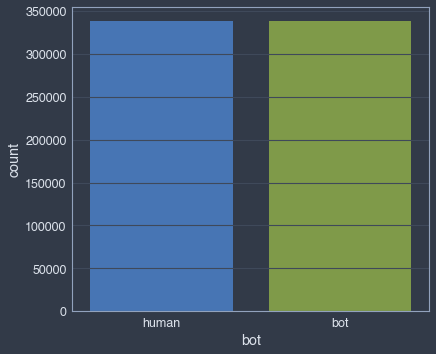

In [39]:
sns.countplot(df['bot'])

## Preproc

In [83]:
# function for text cleaning
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer() 

def clean_text(text):    
    # lowercase 
    text = text.lower()
    
#     # remove urls
#     tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
#     # maybe strip tags
#     tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # strip html tags
    text = html.unescape(text)
    
    # remove non-words
#     text = re.sub('\W', ' ', text)
    
    # remove single chars
#     text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)
    
#     text = replace_num_token(text)
    
    tokenized = tokenizer.tokenize(text)
    tokenized = list(map(lambda x : lemmatizer.lemmatize(x), tokenized))
        
    return tokenized    

def remove_stopwords(tokens):
    return [w for w in tokens if not w in stopwords.words('english')]
  

In [85]:
df_train['clean_tweet_tokenized'] = df_train['tweet'].apply(
    lambda x: clean_text(x))
df_train['clean_tweet_tokenized'] = df_train['clean_tweet_tokenized'].apply(
    lambda x: remove_stopwords(x))
df_train['clean_tweet'] = df_train['clean_tweet_tokenized'].apply(
    lambda x: " ".join(x))
df_train

KeyboardInterrupt: 

In [ ]:
df_test['clean_tweet_tokenized'] = df_test['tweet'].apply(
    lambda x: clean_text(x))
df_test['clean_tweet'] = df_test['clean_tweet_tokenized'].apply(
    lambda x: " ".join(x))
df_test

In [64]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(15,terms / 5))
  ax = sns.barplot(data=d, x= "count", y = "word", color='lightseagreen')
  ax.set(ylabel = 'Word')

  plt.show()
  return words_df.shape[0]

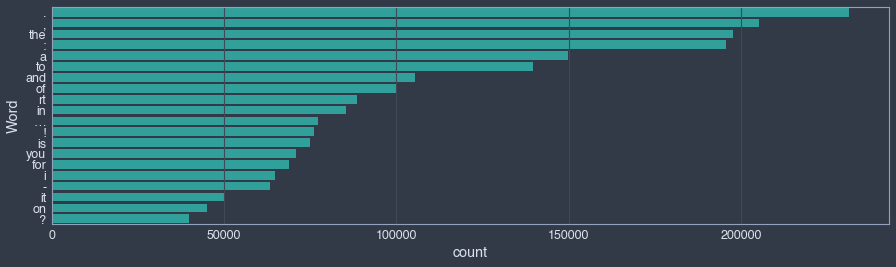

492164


In [68]:
# print 20 most frequent words
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

In [ ]:
# print 20 most frequent words after stop
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")